# Sentiment Analysis with Neural Network
- We will use multiple neural network techniques to uncover people's sentiments. To do this, we will compare the accuracy of all the models.

## Dataset Information

This dataset was created for the Paper 'From Group to Individual Labels using Deep Features', Kotzias et. al,. KDD 2015

It contains sentences labelled with positive or negative sentiment.

[Sentiment Labelled Sentences Link](https://archive.ics.uci.edu/dataset/331/sentiment+labelled+sentences)

### Details:

Score is either 1 (for positive) or 0 (for negative)
The sentences come from three different websites/fields:

>imdb.com
>
>amazon.com
>
>yelp.com

For each website, there exist 500 positive and 500 negative sentences. Those were selected randomly for larger datasets of reviews.
We attempted to select sentences that have a clearly positive or negative connotaton, the goal was for no neutral sentences to be selected.

### Import Necessary Labraries
Libraries required for data processing, visualization, model building, and evaluation in a deep learning project.

In [1]:
!pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.9 MB/s eta 0:00:00


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from keras.backend import clear_session
from keras.models import Sequential
from keras import layers, regularizers
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.optimizers import Adam

# Import Keras Tuner for hyperparameter tuning
import keras_tuner as kt

# Set plot style
plt.style.use("ggplot")

In [ ]:
filepath_dict = {
    "yelp": "yelp_labelled.txt",
    "amazon": "amazon_cells_labelled.txt",
    "imdb": "imdb_labelled.txt",
}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=["sentence", "label"], sep="\t")
    df["source"] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)
df.head(10)

In [ ]:
df.groupby("label").describe().T

label                                 0             1
sentence count                     1362          1386
         unique                    1355          1376
         top     The food was terrible.  Great Phone.
         freq                         2             2
source   count                     1362          1386
         unique                       3             3
         top                       yelp          yelp
         freq                       500           500

In [ ]:
df.groupby(["source", "label"])["label"].count()

source  label
amazon  0        500
        1        500
imdb    0        362
        1        386
yelp    0        500
        1        500
Name: label, dtype: int64

In [ ]:
df[(df["source"] == "yelp") & (df["label"] == 1)]

,sentence,label,source
0,Wow... Loved this place.,1,yelp
3,Stopped by during the late May bank holiday of...,1,yelp
4,The selection on the menu was great and so wer...,1,yelp
8,The fries were great too.,1,yelp
9,A great touch.,1,yelp
...,...,...,...
899,"Overall, a great experience.",1,yelp
901,Their regular toasted bread was equally satisf...,1,yelp
907,The chips and sals a here is amazing!!!!!!!!!!...,1,yelp
909,This is my new fav Vegas buffet spot.,1,yelp


The WordCloud tool will help us visualize the words that appear the most.

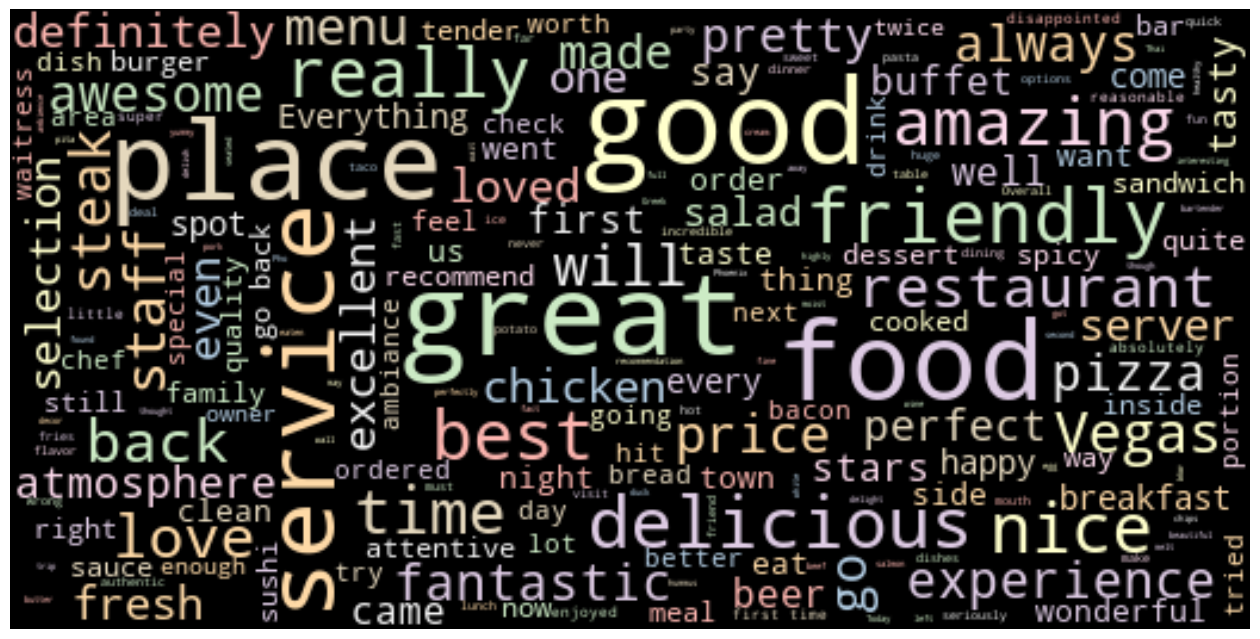

In [ ]:
ham_msg_cloud = WordCloud(
    width=520,
    height=260,
    stopwords=STOPWORDS,
    max_font_size=50,
    background_color="black",
    colormap="Pastel1",
).generate(str(df[(df["label"] == 1) & (df["source"] == "yelp")].sentence.to_list()))
plt.figure(figsize=(16, 10))
plt.imshow(ham_msg_cloud, interpolation="bilinear")
plt.axis("off")  # Turn off axis
plt.show()

For good reviews, the most important words are: GOOD, FOOD, PLACE, SERVICE, GREAT.

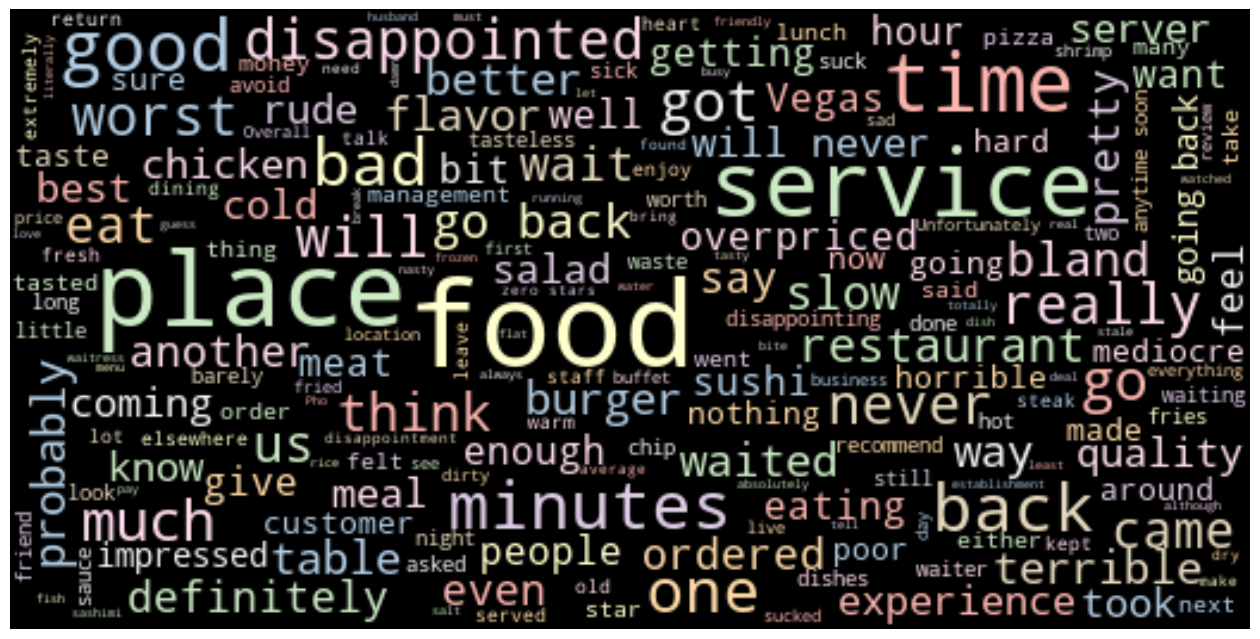

In [ ]:
ham_msg_cloud = WordCloud(
    width=520,
    height=260,
    stopwords=STOPWORDS,
    max_font_size=50,
    background_color="black",
    colormap="Pastel1",
).generate(str(df[(df["label"] == 0) & (df["source"] == "yelp")].sentence.to_list()))
plt.figure(figsize=(16, 10))
plt.imshow(ham_msg_cloud, interpolation="bilinear")
plt.axis("off")  # Turn off axis
plt.show()

For bad reviews, the most important words in this connotation are: PLACE, SERVICE, FOOD, TIME.

In [ ]:
# Get length column for each text
df["text_length"] = df["sentence"].apply(len)
print(df.head())
print(df.describe())

                                            sentence  label source  \
0                           Wow... Loved this place.      1   yelp   
1                                 Crust is not good.      0   yelp   
2          Not tasty and the texture was just nasty.      0   yelp   
3  Stopped by during the late May bank holiday of...      1   yelp   
4  The selection on the menu was great and so wer...      1   yelp   

   text_length  
0           24  
1           18  
2           41  
3           87  
4           59  
             label  text_length
count  2748.000000  2748.000000
mean      0.504367    71.528384
std       0.500072   201.987266
min       0.000000     7.000000
25%       0.000000    32.000000
50%       1.000000    55.000000
75%       1.000000    87.000000
max       1.000000  7944.000000


In [ ]:
print(df[df["text_length"] == 7944]["sentence"].to_string())


def display_text_max_col_width(df, width):
    with pd.option_context("display.max_colwidth", width):
        print(df)


display_text_max_col_width(df[df["text_length"] == 7944]["sentence"], 8000)

136     In fact, it's hard to remember that the part ...
136     In fact, it's hard to remember that the part of Ray Charles is being acted, and not played by the man himself.  \t1\nRay Charles is legendary.  \t1\nRay Charles' life provided excellent biographical material for the film, which goes well beyond being just another movie about a musician.  \t1\nHitchcock is a great director.  \t1\nIronically I mostly find his films a total waste of time to watch.  \t0\nSecondly, Hitchcock pretty much perfected the thriller and chase movie.  \t1\nIt's this pandering to the audience that sabotages most of his films.  \t0\nHence the whole story lacks a certain energy.  \t0\nThe plot simply rumbles on like a machine, desperately depending on the addition of new scenes.  \t0\nThere are the usual Hitchcock logic flaws.  \t0\nMishima is extremely uninteresting.  \t0\nThis is a chilly, unremarkable movie about an author living/working in a chilly abstruse culture.  \t0\nThe flat reenactments don't 

<div class="alert-success">
It is observed that there are 1362 bad reviews and 1386 good reviews, and the labels are balanced in each source, which makes it useful to use the accuracy measure.
</div>

## Benchmark Model
We will use a reference model to compare with more advanced methods involving (deep) neural networks.

In [ ]:
df_yelp = df[df["source"] == "yelp"]

sentences = df_yelp["sentence"].values
y = df_yelp["label"].values

sentences_train, sentences_test, y_train, y_test = train_test_split(
    sentences, y, test_size=0.25, random_state=1000
)

In [ ]:
print(sentences_train[0])
print(y_train[0])

The food was barely lukewarm, so it must have been sitting waiting for the server to bring it out to us.
0


In [ ]:
# Vectorize the sentences
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test = vectorizer.transform(sentences_test)
X_train

<750x1714 sparse matrix of type '<class 'numpy.int64'>'
	with 7368 stored elements in Compressed Sparse Row format>

In [ ]:
X_train.shape

(750, 1714)

The classification model we are going to use is `LogisticRegression`, which is a simple but powerful linear model that, mathematically speaking, is actually a form of regression between 0 and 1 based on the input feature vector. By specifying a cutoff value (default 0.5), the regression model is used for classification.

In [ ]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score)

Accuracy: 0.796


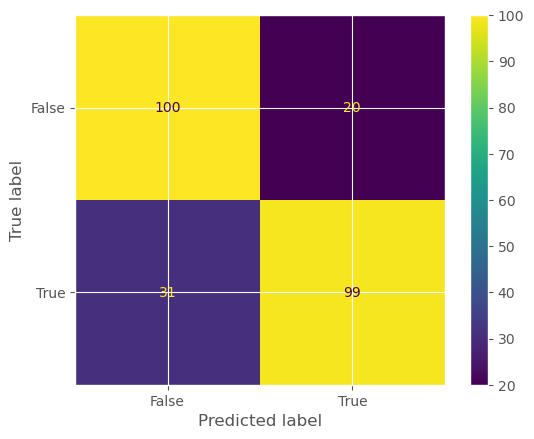

In [ ]:
y_pred = classifier.predict(X_test)

CM = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=[False, True])

cm_display.plot()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.83      0.80       120
           1       0.83      0.76      0.80       130

    accuracy                           0.80       250
   macro avg       0.80      0.80      0.80       250
weighted avg       0.80      0.80      0.80       250



You can see that the logistic regression reached an impressive 79.6%, but let's take a look at how this model performs on the other data sets we have. In this script, we perform and evaluate the entire process for each data set we have:

dim  (250, 1714)
Accuracy for yelp data: 0.7960


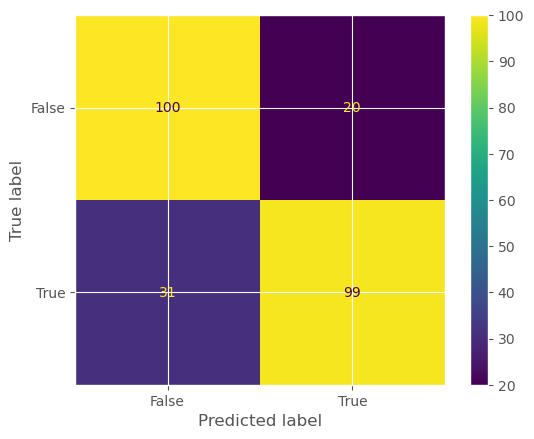

dim  (250, 1546)
Accuracy for amazon data: 0.7960


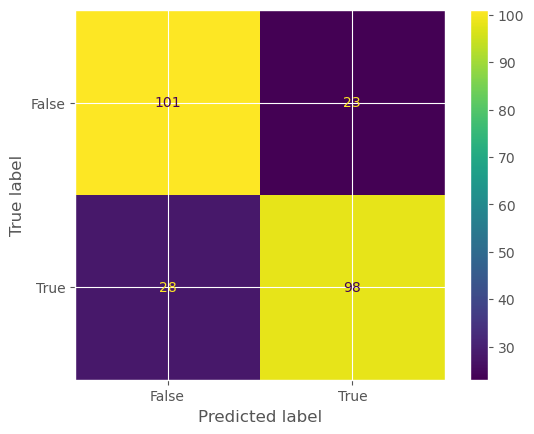

dim  (187, 2505)
Accuracy for imdb data: 0.7487


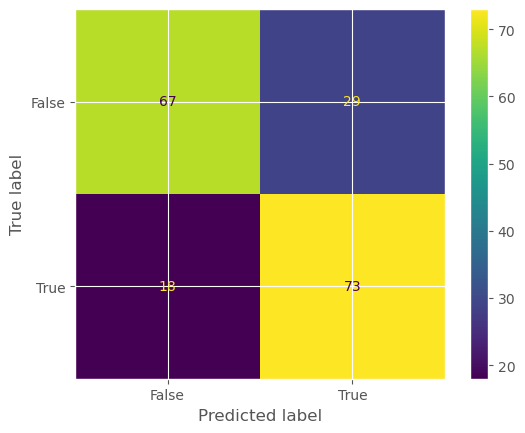

In [ ]:
for source in df["source"].unique():
    df_source = df[df["source"] == source]
    sentences = df_source["sentence"].values
    y = df_source["label"].values

    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000
    )

    vectorizer = CountVectorizer()
    vectorizer.fit(sentences_train)
    X_train = vectorizer.transform(sentences_train)
    X_test = vectorizer.transform(sentences_test)

    print(f"dim  {X_test.shape}")

    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    score = classifier.score(X_test, y_test)
    print("Accuracy for {} data: {:.4f}".format(source, score))

    y_pred = classifier.predict(X_test)

    # Crear la matriz de confusión utilizando sklearn
    CM = confusion_matrix(y_test, y_pred)

    # Crear la visualización de la matriz de confusión
    cm_display = ConfusionMatrixDisplay(
        confusion_matrix=CM, display_labels=[False, True]
    )

    # Graficar la matriz de confusión
    cm_display.plot()
    plt.show()

Excellent! You can see that this simple model achieves pretty good accuracy. It would be interesting to see if we are able to overcome this model using (deep) neural networks.

## Feed Forward Neural Network (FFNN)

- Create a model with at least two hidden layers.

- Train the model.

- The model must obtain an accuracy of at least 80% in test set.

- Explain why accuracy is a good metric for this problem, as well as an example of a problem where it is not good to choose accuracy as a metric.

- Graph training and validation accuracy and Training and validation loss and interpret the graphs.

In [ ]:
# Filter 'yelp' data
df_yelp = df[df["source"] == "yelp"]

sentences = df_yelp["sentence"].values
y = df_yelp["label"].values
sentences_train, sentences_test, y_train, y_test = train_test_split(
    sentences, y, test_size=0.25, random_state=1000
)

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test = vectorizer.transform(sentences_test)

In [ ]:
clear_session()

FFNN = Sequential()
FFNN.add(layers.Dense(5, input_dim=X_train.shape[1], activation="relu"))
FFNN.add(layers.Dense(5, activation="tanh"))
FFNN.add(layers.Dense(5, activation="relu", kernel_regularizer=regularizers.l1(0.01)))
FFNN.add(layers.Dropout(0.5))
FFNN.add(layers.Dense(1, activation="sigmoid"))

FFNN.summary()

FFNN.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history_ffnn = FFNN.fit(
    X_train,
    y_train,
    epochs=50,
    verbose=True,
    validation_data=(X_test, y_test),
    batch_size=5,
)

loss, accuracy = FFNN.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = FFNN.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 8575      
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
 dense_2 (Dense)             (None, 5)                 30        
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 8,641
Trainable params: 8,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


c:\Users\Esnil\.conda\envs\LP\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 5), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


150/150 [==============================] - 2s 7ms/step - loss: 0.7888 - accuracy: 0.5147 - val_loss: 0.7675 - val_accuracy: 0.5960
Epoch 2/50
150/150 [==============================] - 1s 5ms/step - loss: 0.7390 - accuracy: 0.5933 - val_loss: 0.7133 - val_accuracy: 0.7280
Epoch 3/50
150/150 [==============================] - 1s 5ms/step - loss: 0.6545 - accuracy: 0.7000 - val_loss: 0.6362 - val_accuracy: 0.7840
Epoch 4/50
150/150 [==============================] - 1s 5ms/step - loss: 0.5527 - accuracy: 0.7987 - val_loss: 0.5639 - val_accuracy: 0.7720
Epoch 5/50
150/150 [==============================] - 1s 5ms/step - loss: 0.4240 - accuracy: 0.8667 - val_loss: 0.5145 - val_accuracy: 0.7920
Epoch 6/50
150/150 [==============================] - 1s 5ms/step - loss: 0.3407 - accuracy: 0.8893 - val_loss: 0.5094 - val_accuracy: 0.8080
Epoch 7/50
150/150 [==============================] - 1s 5ms/step - loss: 0.3102 - accuracy: 0.9080 - val_loss: 0.4880 - val_accuracy: 0.7840
Epoch 8/50
150/15

In [ ]:
y_pred = FFNN.predict(X_test)
print(y_pred)
y_pred = y_pred.flatten()
print(y_pred.round(2))
# [1. 0.01 0.91 0.87 0.06 0.95 0.24 0.58 0.78 ...

# Extract the predicted class labels
y_pred = np.where(y_pred > 0.5, 1, 0)

8/8 [==============================] - 0s 3ms/step
[[0.01747927]
 [0.01130238]
 [0.00633482]
 [0.00646978]
 [0.4160622 ]
 [0.99836826]
 [0.00632975]
 [0.99848056]
 [0.00722113]
 [0.99729055]
 [0.00636374]
 [0.02312973]
 [0.00726566]
 [0.9643662 ]
 [0.9882158 ]
 [0.9186642 ]
 [0.00846344]
 [0.00723845]
 [0.00638197]
 [0.99852884]
 [0.33716452]
 [0.00889925]
 [0.00632023]
 [0.9961301 ]
 [0.99854845]
 [0.18286964]
 [0.9983994 ]
 [0.00631257]
 [0.00637857]
 [0.00754338]
 [0.00946106]
 [0.0270058 ]
 [0.9976038 ]
 [0.97237664]
 [0.2085802 ]
 [0.00653706]
 [0.99849206]
 [0.33679777]
 [0.01227002]
 [0.01935377]
 [0.1789565 ]
 [0.00736882]
 [0.00826799]
 [0.99847394]
 [0.00631257]
 [0.9984487 ]
 [0.9985026 ]
 [0.9983448 ]
 [0.03650292]
 [0.00630971]
 [0.01011207]
 [0.54071844]
 [0.00644482]
 [0.991925  ]
 [0.0063209 ]
 [0.99749136]
 [0.01577724]
 [0.9972044 ]
 [0.04803081]
 [0.6515018 ]
 [0.99756193]
 [0.00969035]
 [0.99854404]
 [0.9984177 ]
 [0.8229965 ]
 [0.14463861]
 [0.00736426]
 [0.0064339

In [ ]:
print(y_test)

[0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 1 0 0 0 1 1 1 0 1 1 0 1 0 0 0 0 0 1 1 0 0 1
 0 0 0 1 0 1 1 0 1 1 1 0 0 0 1 0 0 1 1 0 1 0 0 1 0 1 1 0 0 0 0 1 0 0 0 1 1
 0 1 1 1 0 1 1 0 0 0 1 0 1 1 1 1 1 0 1 0 0 1 0 0 0 0 1 0 0 1 1 1 0 0 1 1 1
 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0 1 0 1 0
 1 1 1 1 0 1 1 0 1 0 0 1 1 1 0 1 1 0 1 1 1 1 0 0 1 1 0 1 0 0 1 0 1 1 0 0 1
 1 1 0 1 1 1 0 1 1 1 1 0 0 1 1 1 1 0 0 0 1 1 0 0 0 1 0 1 0 0 0 1 1 1 0 1 1
 0 1 1 1 1 0 1 1 0 1 1 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0]


In [ ]:
print(y_pred)

[0 0 0 0 0 1 0 1 0 1 0 0 0 1 1 1 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 1 0 0 1
 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 0 1 0 1 0 1 0 1 1 0 1 1 1 0 0 0 1 0 1 0 0 1
 1 1 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 1 1 0 0 1 0 1 1 1 1 0 0 1 1 1
 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 0 1 1
 1 0 1 1 0 1 1 1 0 0 0 1 1 0 0 1 1 0 1 1 0 1 0 1 1 1 0 1 1 0 1 0 1 1 0 0 0
 1 1 0 1 0 1 0 1 1 1 0 0 1 1 1 1 1 0 0 0 0 1 1 0 0 1 0 0 0 0 0 1 1 1 0 0 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 1 1 1 0 1 0]


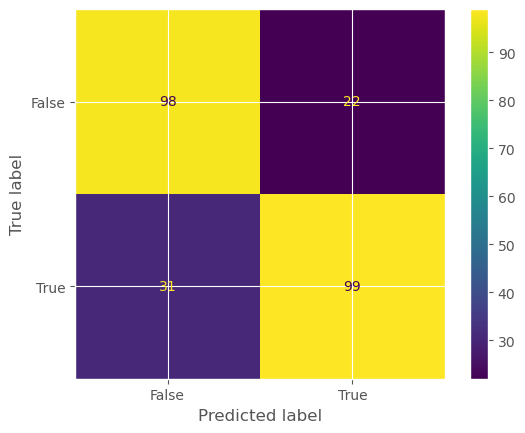

In [ ]:
CM = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=[False, True])

cm_display.plot()
plt.show()

In [ ]:
def plot_confusion_matrix(model, X_test, y_test, threshold=0.5):
    """
    Predicts labels for the test dataset using a given model, computes the confusion matrix,
    and plots the confusion matrix.

    Parameters:
    model (object): The trained model used for making predictions.
    X_test (array-like): The input features of the test dataset.
    y_test (array-like): The true labels of the test dataset.
    threshold (float): The threshold value to convert probabilities to binary class labels. Default is 0.5.

    Returns:
    None
    """
    # Predict probabilities for the test set
    y_pred = model.predict(X_test)
    # Flatten the predicted probabilities array
    y_pred = y_pred.flatten()
    # Convert probabilities to binary class labels based on the threshold
    y_pred = np.where(y_pred > threshold, 1, 0)

    # Compute the confusion matrix
    CM = confusion_matrix(y_test, y_pred)

    # Display the confusion matrix
    cm_display = ConfusionMatrixDisplay(
        confusion_matrix=CM, display_labels=[False, True]
    )
    cm_display.plot()
    plt.show()

dim  (250, 1714)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 8575      
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
 dense_2 (Dense)             (None, 5)                 30        
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 


Total params: 8,641
Trainable params: 8,641
Non-trainable params: 0
_________________________________________________________________


c:\Users\Esnil\.conda\envs\LP\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 5), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Training Accuracy: 0.9987
Testing Accuracy:  0.7760
8/8 [==============================] - 0s 3ms/step


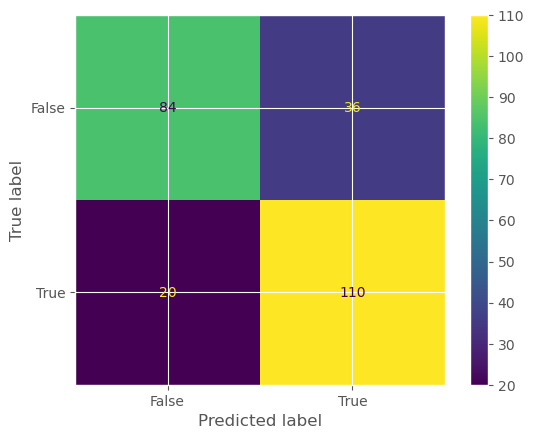

dim  (250, 1546)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 7735      
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
 dense_2 (Dense)             (None, 5)                 30        
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 7,801
Trainable params: 7,801
Non-trainable params: 0
_________________________________________________________________


c:\Users\Esnil\.conda\envs\LP\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 5), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Training Accuracy: 0.9947
Testing Accuracy:  0.7680
8/8 [==============================] - 0s 3ms/step


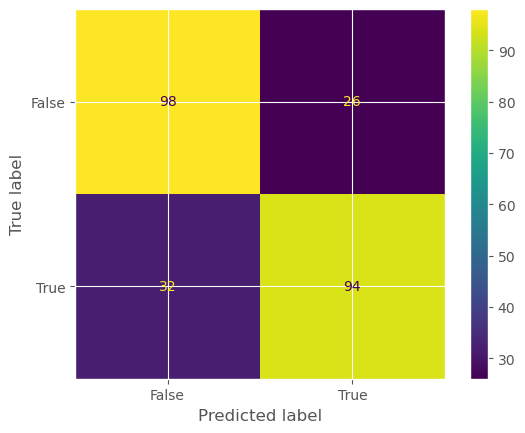

dim  (187, 2505)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 12530     
                                                                 
 dense_1 (Dense)             (None, 5)                 30        
                                                                 
 dense_2 (Dense)             (None, 5)                 30        
                                                                 
 dropout (Dropout)           (None, 5)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 12,596
Trainable params: 12,596
Non-trainable params: 0
_________________________________________________________________


c:\Users\Esnil\.conda\envs\LP\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 5), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


Training Accuracy: 1.0000
Testing Accuracy:  0.7701
6/6 [==============================] - 0s 3ms/step


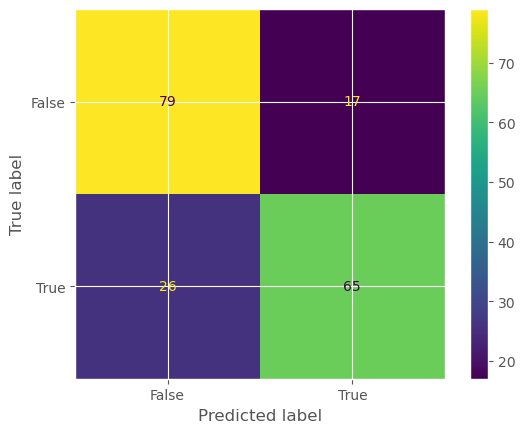

In [ ]:
history_ffnn = {}

for source in df["source"].unique():
    df_source = df[df["source"] == source]
    sentences = df_source["sentence"].values
    y = df_source["label"].values

    sentences_train, sentences_test, y_train, y_test = train_test_split(
        sentences, y, test_size=0.25, random_state=1000
    )

    vectorizer = CountVectorizer()
    vectorizer.fit(sentences_train)
    X_train = vectorizer.transform(sentences_train)
    X_test = vectorizer.transform(sentences_test)

    print(f"dim  {X_test.shape}")

    input_dim = X_train.shape[1]  # Number of features

    clear_session()
    model = Sequential()
    model.add(layers.Dense(5, input_dim=input_dim, activation="relu"))
    model.add(layers.Dense(5, activation="tanh"))
    model.add(
        layers.Dense(5, activation="relu", kernel_regularizer=regularizers.l1(0.01))
    )
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation="sigmoid"))

    model.summary()

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    history_ffnn[source] = model.fit(
        X_train,
        y_train,
        epochs=50,
        verbose=False,
        validation_data=(X_test, y_test),
        batch_size=5,
    )

    loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
    print("Training Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy))

    plot_confusion_matrix(model)

In [ ]:
def plot_history(history):
    """
    Plots the training and validation accuracy and loss from the model's training history.

    Parameters:
    history (History): A History object returned by the fit method of a Keras model, containing the
                       training and validation accuracy and loss values over epochs.

    Returns:
    None
    """
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    x = history.epoch

    plt.figure(figsize=(12, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, "b", label="Training accuracy")
    plt.plot(x, val_acc, "r", label="Validation accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, "b", label="Training loss")
    plt.plot(x, val_loss, "r", label="Validation loss")
    plt.title("Training and Validation Loss")
    plt.legend()

    plt.show()

yelp
amazon
imdb


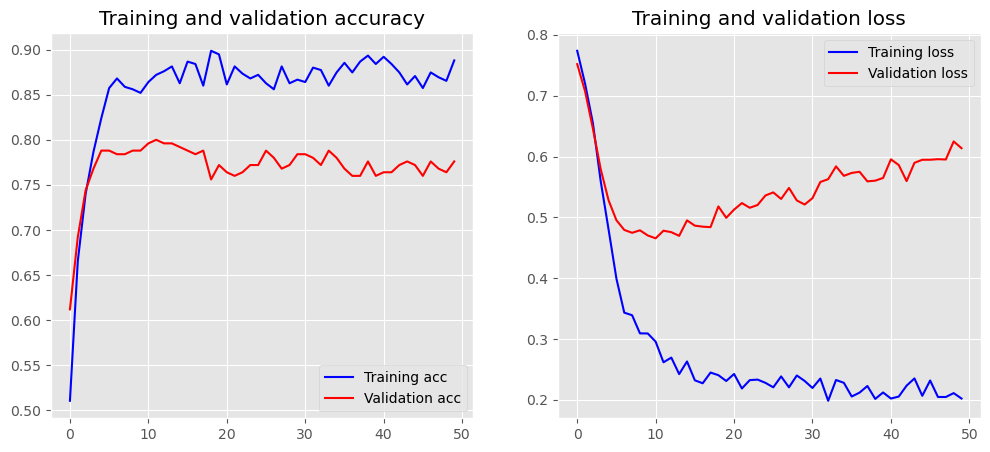

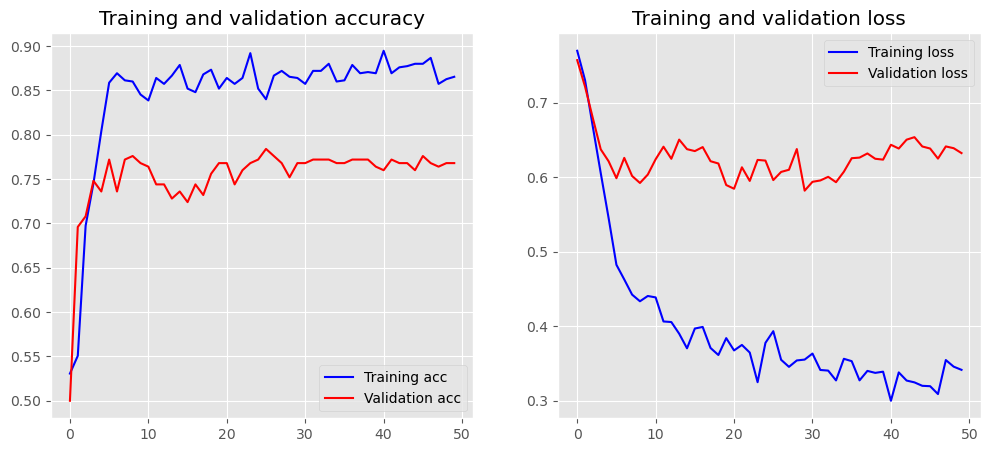

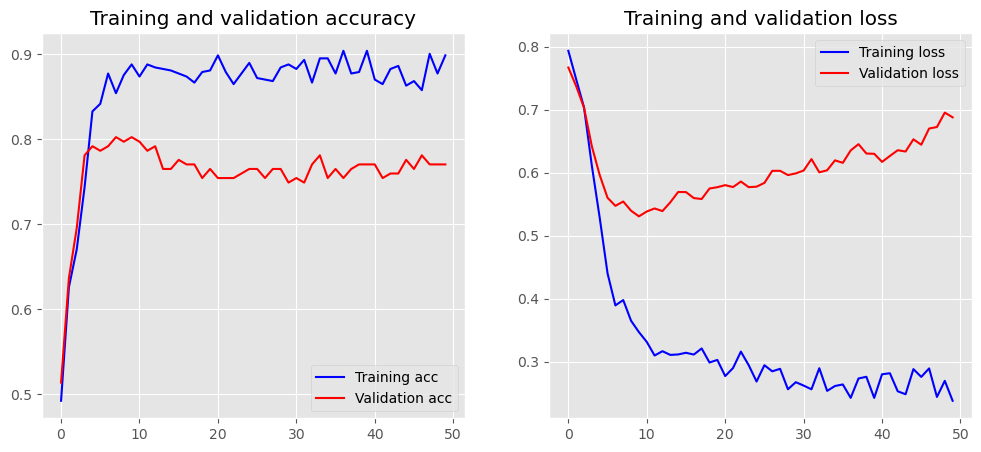

In [ ]:
for source in history_ffnn.keys():
    print(source)
    plot_history(history_ffnn[source])

<div class="alert-success">
The training was done with the three data separately.

- It can be said that accuracy is an appropriate measure for this problem because the data is balanced, one case where it should be used is when there is unbalanced data.

- The accuracy graphs for *yelp*, *amazon* and imdb indicate that after epoch 10 the model stops improving in this measure, but the learning does not overfit.

- The Loss graphs indicate for *yelp*, *amazon* and imdb that the model perhaps begins to learn one class better than another, impairing the ability to generalize.


- With the test data, the model managed to obtain a value comparable to the base model of 77.6%, 76.8% and 77.1%. Note: When you run the model again, you will get different results. One option is to be able to set the randomness of the weights to be able to reproduce the results each time we run the model again.

Example: keras.utils.set_random_seed(812)


</div>


<div class="alert-warning">
We noticed that the model is trained with imdb reviews, so we added the code to start with yelp as in the base case.

You can also notice a small difference between the predict and evaluate methods. The predict delivers continuous values ​​between 0 and 1, what is done is that poor values ​​below 0.5 are assigned 0 and values ​​above 0.5 are assigned 1. This is done to be able to make the confusion matrix. On the other hand, the evaluate method does these predict steps internally.
</div>

<div class="alert-info">
Let's see what happens if we consider the data together for training.
</div>

dim  (687, 4506)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               2253500   
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 500)               250500    
                                                                 
 dense_2 (Dense)             (None, 1)                 501       
                                                                 
Total params: 2,504,501
Trainable params: 2,504,501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
413/413 [==============================] - 7s 15ms/step - loss: 1.3834 - accuracy: 0.6817 - val_loss: 0.8324 - val_accuracy: 0.7875
Epoch 2/50
413/413

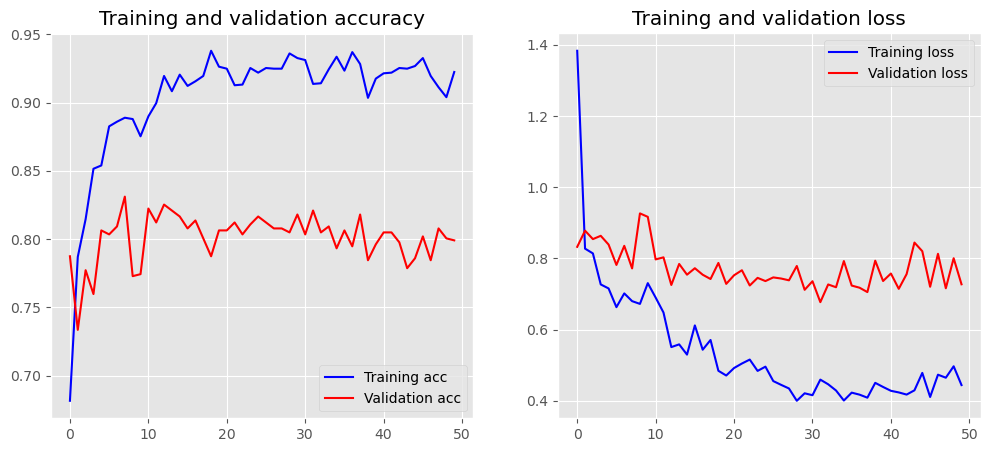

In [ ]:
sentences_train, sentences_test, y_train, y_test = train_test_split(
    df["sentence"].values, df["label"].values, test_size=0.25, random_state=1000
)

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test = vectorizer.transform(sentences_test)

print(f"dim  {X_test.shape}")

keras.utils.set_random_seed(812)

clear_session()
FFNN2 = Sequential()
FFNN2.add(
    layers.Dense(
        500,
        input_dim=X_train.shape[1],
        activation="relu",
        kernel_regularizer=regularizers.l2(0.01),
    )
)
FFNN2.add(layers.Dropout(0.5))
FFNN2.add(
    layers.Dense(500, activation="tanh", kernel_regularizer=regularizers.l2(0.01))
)
FFNN2.add(layers.Dense(1, activation="sigmoid"))

FFNN2.summary()

FFNN2.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history_ffnn2 = FFNN2.fit(
    X_train,
    y_train,
    epochs=50,
    verbose=True,
    validation_data=(X_test, y_test),
    batch_size=5,
)

loss, accuracy = FFNN2.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = FFNN2.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

plot_history(history_ffnn2)

<div class="alert-success">
When we mix the three data and train our FF neural network, we have better convergence behavior, avoid overfitting and improve generalization ability. But it also increases the number of data features to 4506.


On the other hand, we also see that each separate data has a different number of characteristics. If the vocabulary is very large, this number could also be very large because it would be a little inefficient to work with this method.
</div>

## FFNN using: word embeddings

- Train the previous model.

- Graph Training and validation accuracy and Training and validation loss and interpret the graphs.

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[3])
print(X_train[3])
print(vocab_size)

We started with the tuna sashimi which was brownish in color and obviously wasn't fresh.
[56, 296, 15, 1, 1237, 915, 86, 10, 1910, 11, 608, 2, 543, 197, 297]
4603


In [ ]:
maxlen = 500

X_train = pad_sequences(X_train, padding="post", maxlen=maxlen)
X_test = pad_sequences(X_test, padding="post", maxlen=maxlen)

print(X_train[0, :])

[ 278  295  212 1907   39  349    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [ ]:
np.max(X_train)  # Vocabulary length

4602

In [ ]:
print("Vocabulary size", vocab_size)
print("Sequence length", maxlen)

In [ ]:
embedding_dim = 200

keras.utils.set_random_seed(812)

clear_session()
FFNN_EMB = Sequential()
FFNN_EMB.add(
    layers.Embedding(
        input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen
    )
)
FFNN_EMB.add(layers.Flatten())
FFNN_EMB.add(layers.Dense(50, activation="relu"))
FFNN_EMB.add(layers.Dense(1, activation="sigmoid"))
FFNN_EMB.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 200)          920600    
                                                                 
 flatten (Flatten)           (None, 100000)            0         
                                                                 
 dense (Dense)               (None, 50)                5000050   
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 5,920,701
Trainable params: 5,920,701
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10


413/413 [==============================] - 30s 70ms/step - loss: 0.7099 - accuracy: 0.4930 - val_loss: 0.6931 - val_accuracy: 0.5226
Epoch 2/10
413/413 [==============================] - 30s 73ms/step - loss: 0.6924 - accuracy: 0.4881 - val_loss: 0.6931 - val_accuracy: 0.5226
Epoch 3/10
413/413 [==============================] - 28s 69ms/step - loss: 0.6939 - accuracy: 0.4842 - val_loss: 0.6931 - val_accuracy: 0.5226
Epoch 4/10
413/413 [==============================] - 29s 71ms/step - loss: 0.6929 - accuracy: 0.4731 - val_loss: 0.6932 - val_accuracy: 0.4774
Epoch 5/10
413/413 [==============================] - 29s 70ms/step - loss: 0.7124 - accuracy: 0.4886 - val_loss: 0.6870 - val_accuracy: 0.5415
Epoch 6/10
413/413 [==============================] - 30s 72ms/step - loss: 0.6277 - accuracy: 0.6623 - val_loss: 0.5563 - val_accuracy: 0.7118
Epoch 7/10
413/413 [==============================] - 28s 69ms/step - loss: 0.3201 - accuracy: 0.8743 - val_loss: 0.5355 - val_accuracy: 0.7758
Epo

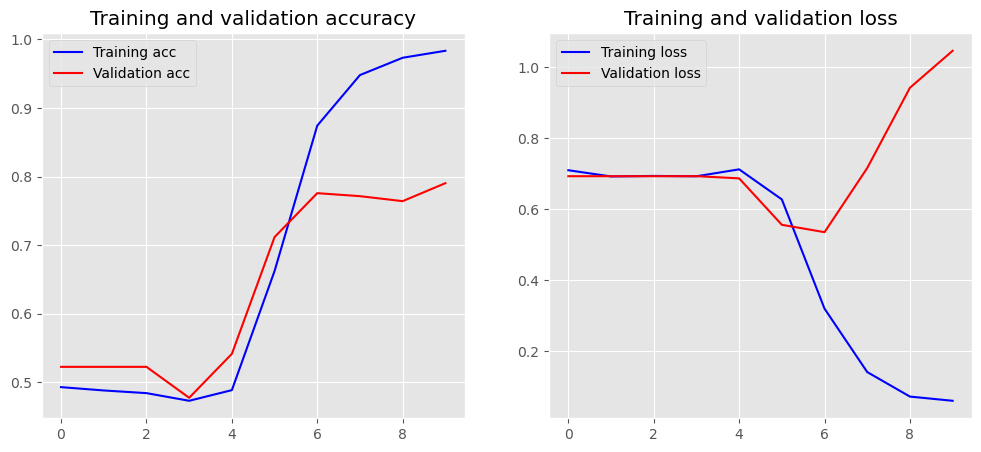

In [ ]:
FFNN_EMB.compile(optimizer="RMSprop", loss="binary_crossentropy", metrics=["accuracy"])

history_ffnn_we1 = FFNN_EMB.fit(
    X_train,
    y_train,
    epochs=10,
    verbose=True,
    validation_data=(X_test, y_test),
    batch_size=5,
)
loss, accuracy = FFNN_EMB.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = FFNN_EMB.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_ffnn_we1)

<div class="alert-success">
This time, I spent a little more time trying out various models. What I found is that the number of neurons was very low, so I raised it to 50 neurons, I also realized that the optimizer was not adequate because it always stuck in the loss function, so I changed it to RMSprop, and it worked much better. Although the Loss graph begins to lose generalization at a certain time, an acc of almost 80% can be obtained. Maybe it is worth adding a regularization method.

</div>

Another way to work with embedding is by using a MaxPooling1D/ AveragePooling1D or GlobalMaxPooling1D/ GlobalAveragePooling1D layer after embedding.

## FFNN using: GlobalMaxPooling1D

- Train the previous model.

- Graph Training and validation accuracy and Training and validation loss and interpret the graphs.

In [ ]:
embedding_dim = 200

keras.utils.set_random_seed(812)

clear_session()
FFNN_EMB_Glob = Sequential()
FFNN_EMB_Glob.add(
    layers.Embedding(
        input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen
    )
)
FFNN_EMB_Glob.add(layers.GlobalMaxPooling1D())
FFNN_EMB_Glob.add(layers.Dense(10, activation="relu"))
FFNN_EMB_Glob.add(layers.Dense(1, activation="sigmoid"))

FFNN_EMB_Glob.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 200)          920600    
                                                                 
 global_max_pooling1d (Globa  (None, 200)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                2010      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 922,621
Trainable params: 922,621
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10


413/413 [==============================] - 6s 13ms/step - loss: 0.6247 - accuracy: 0.6618 - val_loss: 0.4916 - val_accuracy: 0.8239
Epoch 2/10
413/413 [==============================] - 5s 12ms/step - loss: 0.3385 - accuracy: 0.8971 - val_loss: 0.3728 - val_accuracy: 0.8443
Epoch 3/10
413/413 [==============================] - 5s 12ms/step - loss: 0.1470 - accuracy: 0.9641 - val_loss: 0.3892 - val_accuracy: 0.8282
Epoch 4/10
413/413 [==============================] - 5s 12ms/step - loss: 0.0628 - accuracy: 0.9874 - val_loss: 0.4063 - val_accuracy: 0.8384
Epoch 5/10
413/413 [==============================] - 6s 14ms/step - loss: 0.0314 - accuracy: 0.9956 - val_loss: 0.4335 - val_accuracy: 0.8311
Epoch 6/10
413/413 [==============================] - 6s 14ms/step - loss: 0.0181 - accuracy: 0.9976 - val_loss: 0.4706 - val_accuracy: 0.8180
Epoch 7/10
413/413 [==============================] - 5s 12ms/step - loss: 0.0090 - accuracy: 0.9990 - val_loss: 0.5204 - val_accuracy: 0.8108
Epoch 8/10

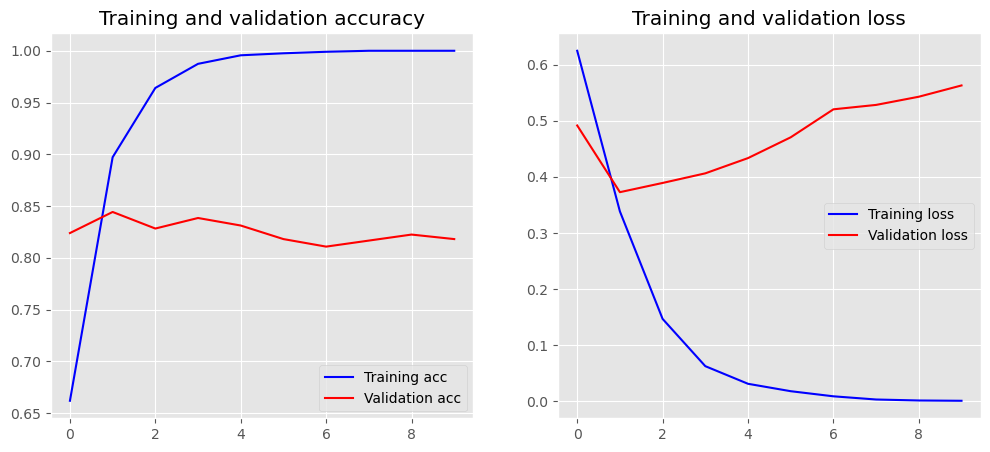

In [ ]:
FFNN_EMB_Glob.compile(
    optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]
)

history_ffnn_we2 = FFNN_EMB_Glob.fit(
    X_train,
    y_train,
    epochs=10,
    verbose=True,
    validation_data=(X_test, y_test),
    batch_size=5,
)
loss, accuracy = FFNN_EMB_Glob.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = FFNN_EMB_Glob.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_ffnn_we2)

<div class="alert-success">
Using GlobalMaxPooling1D allows me to have a behavior similar to the previous case with few neurons, reducing the capacity of the model, and therefore, the computational capacity. In this case, it is necessary to apply some regularization technique.
</div>

### Using Conv1D

In [ ]:
embedding_dim = 200

keras.utils.set_random_seed(812)

clear_session()
modelConv1D = Sequential()
modelConv1D.add(
    layers.Embedding(
        input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen
    )
)
modelConv1D.add(layers.Conv1D(32, 7, activation="relu"))
modelConv1D.add(layers.MaxPooling1D(5))
modelConv1D.add(layers.Conv1D(32, 7, activation="relu"))
modelConv1D.add(layers.GlobalMaxPooling1D())
modelConv1D.add(layers.Dense(1, activation="sigmoid"))
modelConv1D.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 200)          920600    
                                                                 
 conv1d (Conv1D)             (None, 494, 32)           44832     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 98, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 92, 32)            7200      
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 3

Epoch 1/10


413/413 [==============================] - 11s 23ms/step - loss: 0.6116 - accuracy: 0.6361 - val_loss: 0.4408 - val_accuracy: 0.8108
Epoch 2/10
413/413 [==============================] - 9s 22ms/step - loss: 0.2733 - accuracy: 0.8971 - val_loss: 0.4301 - val_accuracy: 0.8151
Epoch 3/10
413/413 [==============================] - 9s 22ms/step - loss: 0.0619 - accuracy: 0.9820 - val_loss: 0.4986 - val_accuracy: 0.8355
Epoch 4/10
413/413 [==============================] - 9s 22ms/step - loss: 0.0118 - accuracy: 0.9981 - val_loss: 0.5891 - val_accuracy: 0.8326
Epoch 5/10
413/413 [==============================] - 9s 22ms/step - loss: 0.0040 - accuracy: 0.9990 - val_loss: 0.6280 - val_accuracy: 0.8268
Epoch 6/10
413/413 [==============================] - 9s 22ms/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.6618 - val_accuracy: 0.8253
Epoch 7/10
413/413 [==============================] - 9s 22ms/step - loss: 9.5268e-04 - accuracy: 0.9995 - val_loss: 0.6961 - val_accuracy: 0.8253
Epoch

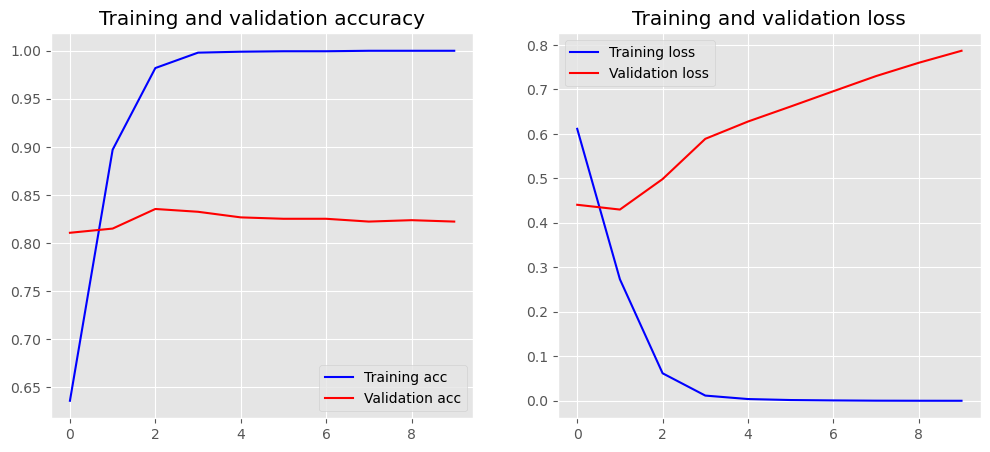

In [ ]:
modelConv1D.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history_ffnn_conv1 = modelConv1D.fit(
    X_train,
    y_train,
    epochs=10,
    verbose=True,
    validation_data=(X_test, y_test),
    batch_size=5,
)
loss, accuracy = modelConv1D.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = modelConv1D.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_ffnn_conv1)

<div class="alert-success">
Using Conv1D we managed to have better performance with an acc above 80%. However, some regularization technique must be used.
</div>

## Pre-Trained Word Embeddings

Another alternative is to use a precomputed embedding space that uses a much larger corpus. It is possible to precompute word embeddings simply by training them on a large text corpus. Among the most popular methods are Word2Vec developed by Google and GloVe (Global Vectors for Word Representation) developed by Stanford NLP Group.

Keep in mind that those are different approaches with the same goal. Word2Vec achieves this using neural networks and GloVe achieves this with a co-occurrence matrix and by using matrix factorization. In both cases it is a dimensionality reduction, but Word2Vec is more precise and GloVe is faster to calculate.

### Downloading GloVe

We are going to use the GloVe pretrained immersion that has been created from the English Wikipedia in 2014 https://nlp.stanford.edu/projects/glove/. It is an 822MB file called `glove.6B.zip`, and contains a 100D vector immersion of 400,000 words.

In [4]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip -d glove.6B

--2024-07-25 19:24:21--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-07-25 19:24:21--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-07-25 19:24:21--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [5]:
glove_dir = "glove.6B"

embeddings_index = {}
f = open(os.path.join(glove_dir, "glove.6B.50d.txt"))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embeddings_index[word] = coefs
f.close()

print("%s word vectors." % len(embeddings_index))

400000 word vectors.


Next, we have to build the matrix that we will load into the immersion layer. It must be of size `(max_words, embedding_dim)`, where each entry $i$ contains the size vector `embedding_dim` for the $i$-th word in the index (constructed during tokenization). Index 0 is not used for any words.

In [ ]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[
                    :embedding_dim
                ]

    return embedding_matrix

In [ ]:
embedding_dim = 300
embedding_matrix = create_embedding_matrix(
    "glove.6B/glove.6B.300d.txt", tokenizer.word_index, embedding_dim
)

In [ ]:
embedding_matrix.shape

(4603, 300)

When using pre-trained word embeddings, you have the option of allowing the embedding to update during training or just using the resulting embedding vectors as-is.

First, let's take a quick look at how many of the embedding vectors are non-zero:

In [ ]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(nonzero_elements)
nonzero_elements / vocab_size

4339


0.9426461003693244

This means that the pre-trained model covers 94.2% of the vocabulary, which is good coverage of our vocabulary. Let's take a look at the performance when using the GlobalMaxPooling1D layer:

In [ ]:
keras.utils.set_random_seed(812)

clear_session()
glove_F = Sequential()
glove_F.add(
    layers.Embedding(
        vocab_size,
        embedding_dim,
        weights=[embedding_matrix],
        input_length=maxlen,
        trainable=False,
    )
)
glove_F.add(layers.GlobalMaxPooling1D())
glove_F.add(layers.Dense(20, activation="relu"))
glove_F.add(layers.Dense(1, activation="sigmoid"))
glove_F.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
glove_F.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          1380900   
                                                                 
 global_max_pooling1d (Globa  (None, 300)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 20)                6020      
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,386,941
Trainable params: 6,041
Non-trainable params: 1,380,900
_________________________________________________________________


Epoch 1/50


413/413 [==============================] - 3s 6ms/step - loss: 0.6463 - accuracy: 0.6410 - val_loss: 0.5764 - val_accuracy: 0.7394
Epoch 2/50
413/413 [==============================] - 2s 5ms/step - loss: 0.5614 - accuracy: 0.7132 - val_loss: 0.5152 - val_accuracy: 0.7744
Epoch 3/50
413/413 [==============================] - 2s 5ms/step - loss: 0.5049 - accuracy: 0.7598 - val_loss: 0.5087 - val_accuracy: 0.7496
Epoch 4/50
413/413 [==============================] - 2s 5ms/step - loss: 0.4756 - accuracy: 0.7773 - val_loss: 0.4866 - val_accuracy: 0.7656
Epoch 5/50
413/413 [==============================] - 2s 5ms/step - loss: 0.4569 - accuracy: 0.7885 - val_loss: 0.4614 - val_accuracy: 0.7948
Epoch 6/50
413/413 [==============================] - 2s 5ms/step - loss: 0.4496 - accuracy: 0.7894 - val_loss: 0.4543 - val_accuracy: 0.7977
Epoch 7/50
413/413 [==============================] - 2s 5ms/step - loss: 0.4320 - accuracy: 0.8020 - val_loss: 0.4746 - val_accuracy: 0.7715
Epoch 8/50
413/41

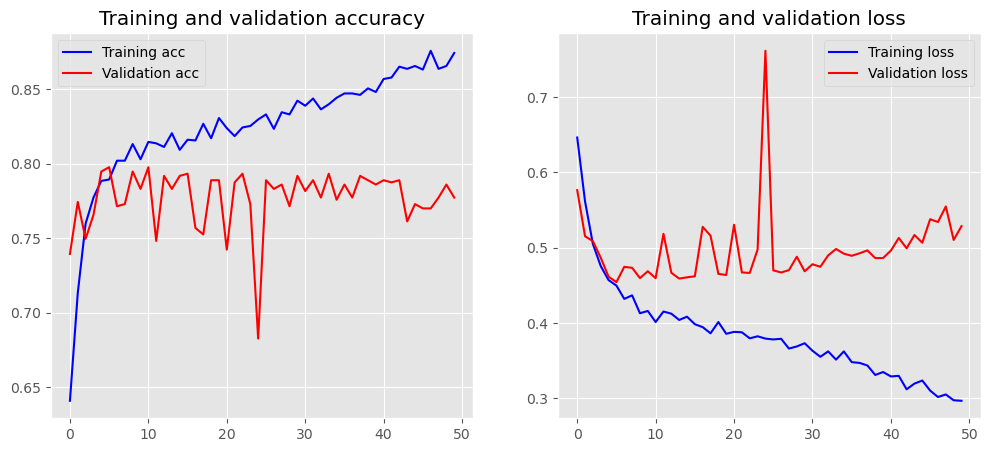

In [ ]:
history_ffnn_we3 = glove_F.fit(
    X_train,
    y_train,
    epochs=50,
    verbose=True,
    validation_data=(X_test, y_test),
    batch_size=5,
)
loss, accuracy = glove_F.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = glove_F.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_ffnn_we3)

<div class="alert-success">
Using embending with trained non-trainable weights, we obtain behavior similar to those seen previously. Acc approx 80% and loss generalizes better. I raised the number of neurons in the densely connected layer to 20 to slightly increase the capacity of the model.
</div>

Now let's see how this works if we allow the embedding to be trained using `trainable=True`:

In [ ]:
keras.utils.set_random_seed(812)

clear_session()
glove_T = Sequential()
glove_T.add(
    layers.Embedding(
        vocab_size,
        embedding_dim,
        weights=[embedding_matrix],
        input_length=maxlen,
        trainable=True,
    )
)
glove_T.add(layers.GlobalMaxPooling1D())
glove_T.add(layers.Dense(20, activation="relu"))
glove_T.add(layers.Dense(1, activation="sigmoid"))
glove_T.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
glove_T.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          1380900   
                                                                 
 global_max_pooling1d (Globa  (None, 300)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 20)                6020      
                                                                 
 dense_1 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,386,941
Trainable params: 1,386,941
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50


413/413 [==============================] - 7s 15ms/step - loss: 0.6250 - accuracy: 0.6672 - val_loss: 0.5223 - val_accuracy: 0.8035
Epoch 2/50
413/413 [==============================] - 6s 15ms/step - loss: 0.3826 - accuracy: 0.8544 - val_loss: 0.3907 - val_accuracy: 0.8355
Epoch 3/50
413/413 [==============================] - 6s 15ms/step - loss: 0.1802 - accuracy: 0.9500 - val_loss: 0.3736 - val_accuracy: 0.8443
Epoch 4/50
413/413 [==============================] - 6s 15ms/step - loss: 0.0749 - accuracy: 0.9845 - val_loss: 0.3858 - val_accuracy: 0.8399
Epoch 5/50
413/413 [==============================] - 6s 15ms/step - loss: 0.0290 - accuracy: 0.9971 - val_loss: 0.4048 - val_accuracy: 0.8355
Epoch 6/50
413/413 [==============================] - 6s 14ms/step - loss: 0.0127 - accuracy: 0.9995 - val_loss: 0.4307 - val_accuracy: 0.8282
Epoch 7/50
413/413 [==============================] - 6s 14ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.4476 - val_accuracy: 0.8326
Epoch 8/50

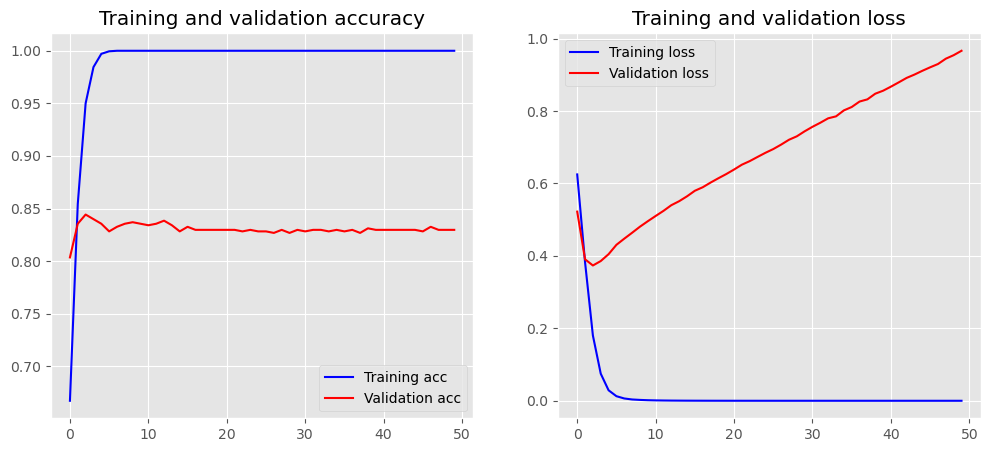

In [ ]:
history_ffnn_we4 = glove_T.fit(
    X_train,
    y_train,
    epochs=50,
    verbose=True,
    validation_data=(X_test, y_test),
    batch_size=5,
)
loss, accuracy = glove_T.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = glove_T.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_ffnn_we4)

<div class="alert-success">
By adjusting the weights that are trainable, the stability of the convergence is improved, an acc of 85% is achieved, but the loss function begins to deteriorate in the validation data, which loses generalization. Regularization techniques need to be used in this case.
</div>

## Convolutional Neural Networks (CNN)

Now is the time to focus on a more advanced neural network model to see if it is possible to boost the model and give it an advantage over previous models.

- Use the previous model and create a model with at least two Conv1D layers between the Embedding layer and the GlobalMaxPool1D layer.

- Train the model.

- The model must obtain an accuracy of at least 80% in test set

- Graph Training and validation accuracy and Training and validation loss and interpret the graphs.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          1380900   
                                                                 
 conv1d (Conv1D)             (None, 494, 32)           67232     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 100)               3300      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1010      
                                                        

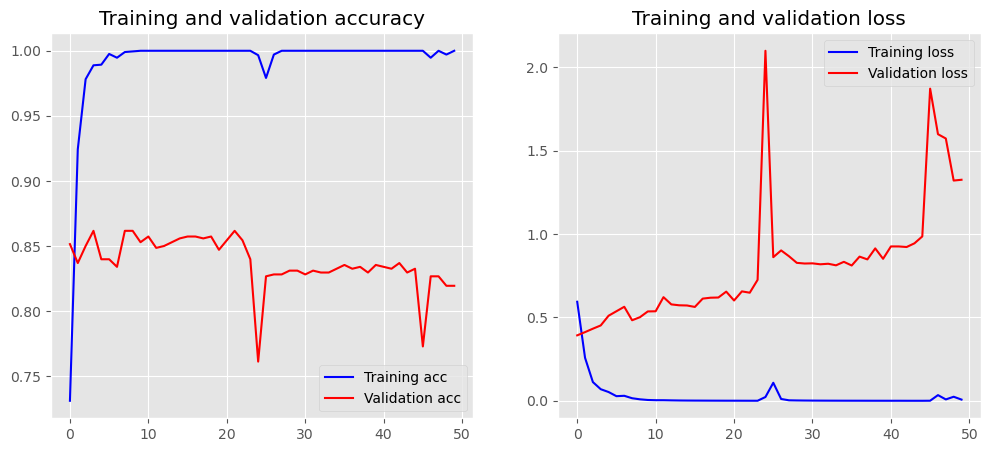

In [ ]:
embedding_dim = 300

keras.utils.set_random_seed(812)

clear_session()
GloveConv1D = Sequential()
GloveConv1D.add(
    layers.Embedding(
        vocab_size,
        embedding_dim,
        weights=[embedding_matrix],
        input_length=maxlen,
        trainable=True,
    )
)
GloveConv1D.add(layers.Conv1D(32, 7, activation="relu"))
GloveConv1D.add(layers.GlobalMaxPooling1D())
GloveConv1D.add(layers.Dense(100, activation="relu"))
GloveConv1D.add(layers.Dropout(0.3))
GloveConv1D.add(
    layers.Dense(10, activation="tanh", kernel_regularizer=regularizers.l2(0.01))
)
GloveConv1D.add(layers.Dense(1, activation="sigmoid"))
GloveConv1D.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
GloveConv1D.summary()

history_cnn = GloveConv1D.fit(
    X_train,
    y_train,
    epochs=50,
    verbose=True,
    validation_data=(X_test, y_test),
    batch_size=5,
)
loss, accuracy = GloveConv1D.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = GloveConv1D.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_cnn)

<div class="alert-success">
When we start using this class of neural networks, the acc begins to improve significantly, demonstrating the power of deep learning. Of course, it is clearly seen in the graphs that methods are required to improve the convergence of the loss function in the validation data. Also, modifying the network structure and testing with other optimizers.
</div>

## Recurrent Neural Networks (RNN)

- Removing the GlobalMaxPool1D layer from the previous model, create a model with at least one SimpleRNN or LSTM or GRU layer between the Embedding layer and the Dense layer, use return_sequences=False as a parameter of the selected layer.

- The model must obtain an accuracy of at least 80% in the test set.

- Graph Training and validation accuracy and Training and validation loss and interpret the graphs.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          1380900   
                                                                 
 conv1d (Conv1D)             (None, 494, 32)           67232     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 98, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 92, 64)            14400     
                                                                 
 lstm (LSTM)                 (None, 92, 32)            12416     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                         

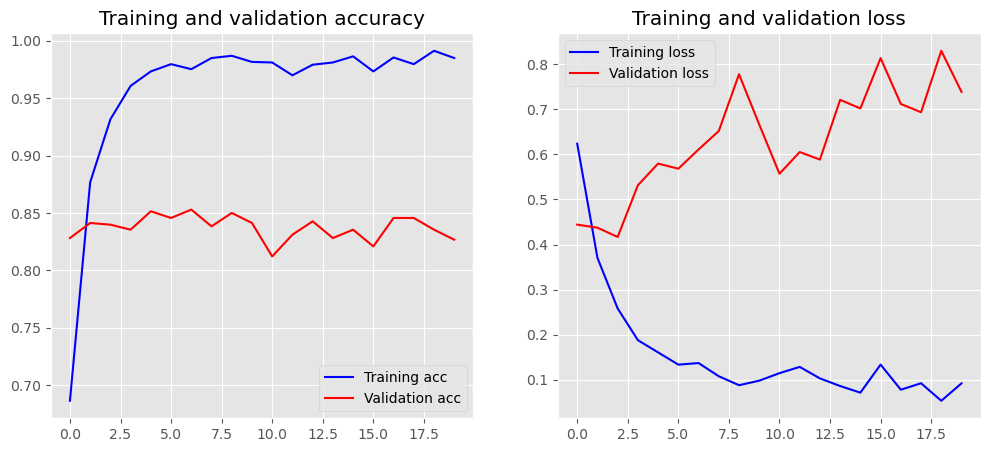

In [ ]:
embedding_dim = 300
embedding_matrix = create_embedding_matrix(
    "glove.6B/glove.6B.300d.txt", tokenizer.word_index, embedding_dim
)

keras.utils.set_random_seed(812)

clear_session()
RNN = Sequential()
RNN.add(
    layers.Embedding(
        vocab_size,
        embedding_dim,
        weights=[embedding_matrix],
        input_length=maxlen,
        trainable=True,
    )
)
RNN.add(
    layers.Conv1D(32, 7, activation="relu", kernel_regularizer=regularizers.l2(0.001))
)
RNN.add(layers.MaxPooling1D(5))
RNN.add(
    layers.Conv1D(64, 7, activation="relu", kernel_regularizer=regularizers.l2(0.001))
)
RNN.add(layers.LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
RNN.add(layers.GlobalMaxPooling1D())
RNN.add(layers.Dense(10, activation="relu", kernel_regularizer=regularizers.l2(0.001)))
RNN.add(layers.Dense(1, activation="sigmoid"))
RNN.compile(optimizer="RMSprop", loss="binary_crossentropy", metrics=["accuracy"])
RNN.summary()

history_rnn = RNN.fit(
    X_train,
    y_train,
    epochs=20,
    verbose=True,
    validation_data=(X_test, y_test),
    batch_size=5,
)
loss, accuracy = RNN.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = RNN.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_rnn)

<div class="alert-success">
This other case was difficult to solve, it took a lot of time to achieve acceptable convergence behavior. I had to add the GlobalMaxPooling1D layer to achieve this. Also use regularization techniques. However, it follows the model, losing generalization and accuracy.
</div>

4339
0.9426461003693244
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          1380900   
                                                                 
 conv1d (Conv1D)             (None, 494, 32)           67232     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 98, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 92, 64)            14400     
                                                                 
 spatial_dropout1d (SpatialD  (None, 92, 64)           0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (No

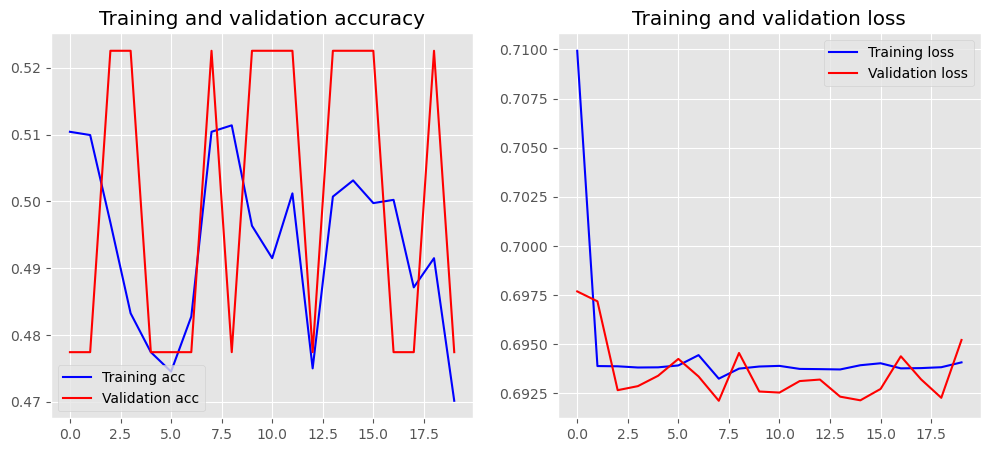

In [ ]:
# Define initial learning rate
initial_learning_rate = 0.01

# Define decay rate
decay_rate = 0.1

# Define decay steps
decay_steps = 10000


# Define learning rate decay function
def lr_time_based_decay(epoch, lr):
    return lr * 1 / (1 + decay_rate * epoch / decay_steps)


# Initialize Adam optimizer with learning rate decay
adam_optimizer = Adam(learning_rate=initial_learning_rate)

sentences_train, sentences_test, y_train, y_test = train_test_split(
    df["sentence"].values, df["label"].values, test_size=0.25, random_state=1000
)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

embedding_dim = 300
embedding_matrix = create_embedding_matrix(
    "glove.6B/glove.6B.300d.txt", tokenizer.word_index, embedding_dim
)

nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(nonzero_elements)
print(nonzero_elements / vocab_size)

maxlen = 500

X_train = pad_sequences(X_train, padding="post", maxlen=maxlen)
X_test = pad_sequences(X_test, padding="post", maxlen=maxlen)

keras.utils.set_random_seed(812)

clear_session()
RNN2 = Sequential()
RNN2.add(
    layers.Embedding(
        vocab_size,
        embedding_dim,
        weights=[embedding_matrix],
        input_length=maxlen,
        trainable=True,
    )
)
RNN2.add(
    layers.Conv1D(32, 7, activation="relu", kernel_regularizer=regularizers.l2(0.001))
)
RNN2.add(layers.MaxPooling1D(5))
RNN2.add(
    layers.Conv1D(64, 7, activation="relu", kernel_regularizer=regularizers.l2(0.001))
)
RNN2.add(layers.SpatialDropout1D(0.2))
RNN2.add(layers.LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
RNN2.add(layers.GlobalMaxPooling1D())
RNN2.add(layers.Dense(10, activation="relu", kernel_regularizer=regularizers.l2(0.001)))
RNN2.add(layers.Dense(1, activation="sigmoid"))
RNN2.summary()


RNN2.compile(optimizer=adam_optimizer, loss="binary_crossentropy", metrics=["accuracy"])
RNN2.summary()

history_rnn2 = RNN2.fit(
    X_train,
    y_train,
    epochs=20,
    verbose=True,
    validation_data=(X_test, y_test),
    batch_size=5,
)
loss, accuracy = RNN2.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = RNN2.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_rnn2)

<div class="alert-success">
The same exercise is done using another regularization layer and a customization of the learning rate of the adam optimizer. But the same problem as the previous model remains. Given this, and how difficult it is to manually adjust each parameter. We will use a method to optimize the most suitable parameters for my model using RNN.
</div>

In [ ]:
def model_builder(hp):
    keras.utils.set_random_seed(812)

    clear_session()
    model = Sequential()
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 8-512
    hp_units1 = hp.Int("units1", min_value=8, max_value=512, step=32)
    hp_units2 = hp.Int("units2", min_value=8, max_value=512, step=32)
    hp_units3 = hp.Int("units3", min_value=8, max_value=512, step=32)

    fun_acti1 = hp.Choice(
        "dense_activation1", values=["relu", "tanh", "sigmoid"], default="relu"
    )
    fun_acti2 = hp.Choice(
        "dense_activation2", values=["relu", "tanh", "sigmoid"], default="relu"
    )

    lr = hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])
    reg = hp.Choice("reg_value", [1e-2, 1e-3, 1e-4])

    model.add(
        layers.Embedding(
            vocab_size,
            embedding_dim,
            weights=[embedding_matrix],
            input_length=maxlen,
            trainable=True,
        )
    )
    model.add(
        layers.Conv1D(
            32, 7, activation="relu", kernel_regularizer=regularizers.l2(0.001)
        )
    )
    model.add(layers.MaxPooling1D(5))
    model.add(
        layers.Conv1D(
            64, 7, activation="relu", kernel_regularizer=regularizers.l2(0.001)
        )
    )
    model.add(layers.SpatialDropout1D(0.2))
    model.add(
        layers.LSTM(
            units=hp_units1, return_sequences=True, dropout=0.2, recurrent_dropout=0.2
        )
    )
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(units=hp_units2, activation=fun_acti1))
    model.add(
        layers.Dropout(
            hp.Float("dropout", min_value=0.0, max_value=0.5, default=0.005, step=0.05)
        )
    )
    model.add(
        layers.Dense(
            units=hp_units3,
            activation=fun_acti2,
            kernel_regularizer=regularizers.l2(reg),
        )
    )
    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(optimizer=Adam(lr), loss="binary_crossentropy", metrics="accuracy")

    return model

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

tuner_BO = kt.BayesianOptimization(
    model_builder,
    objective="val_accuracy",
    max_trials=10,
    directory="my_dir_bo",
    project_name="intro_to_kt",
)

In [ ]:
tuner_BO.search(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[stop_early],
)

Trial 10 Complete [00h 13m 08s]
val_accuracy: 0.8180494904518127

Best val_accuracy So Far: 0.8558952212333679
Total elapsed time: 01h 56m 43s
INFO:tensorflow:Oracle triggered exit


<div class="alert-success">
Since the previous models were not as powerful as expected from RNNs, I decided to use hyperparameter tuning. What I did was take the last model, and added the parameters that I wanted to optimize. The optimal number of neurons, the best activation function, the learning rate and the regularization value. This almost always delivers good performance in the end, and is useful when we fail to train a good model. But it requires a very high computational effort.
</div>

In [ ]:
# Extract the best 'turner_bo'
best_model = tuner_BO.get_best_models()[0]
best_model.evaluate(X_test, y_test)

22/22 [==============================] - 3s 92ms/step - loss: 0.4191 - accuracy: 0.8559


[0.4191161096096039, 0.8558952212333679]

In [ ]:
best_model.build(X_train.shape)
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          1380900   
                                                                 
 conv1d (Conv1D)             (None, 494, 32)           67232     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 98, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 92, 64)            14400     
                                                                 
 spatial_dropout1d (SpatialD  (None, 92, 64)           0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 92, 232)           2

In [ ]:
# Display best parameters
for h_param in (
    [f"units{i}" for i in range(1, 4)]
    + ["learning_rate"]
    + ["dropout"]
    + ["reg_value"]
    + [f"dense_activation{i}" for i in range(1, 3)]
):
    print(tuner_BO.get_best_hyperparameters()[0].get(h_param))

232
328
456
0.001
0.25
0.0001
sigmoid
sigmoid


In [ ]:
history_kt = best_model.fit(
    X_train, y_train, epochs=20, validation_data=(X_test, y_test)
)

Epoch 1/20


65/65 [==============================] - 54s 754ms/step - loss: 0.2174 - accuracy: 0.9505 - val_loss: 0.4592 - val_accuracy: 0.8370
Epoch 2/20
65/65 [==============================] - 48s 741ms/step - loss: 0.1431 - accuracy: 0.9791 - val_loss: 0.4971 - val_accuracy: 0.8443
Epoch 3/20
65/65 [==============================] - 49s 749ms/step - loss: 0.1079 - accuracy: 0.9893 - val_loss: 0.6115 - val_accuracy: 0.8472
Epoch 4/20
65/65 [==============================] - 51s 786ms/step - loss: 0.1380 - accuracy: 0.9753 - val_loss: 0.6087 - val_accuracy: 0.8428
Epoch 5/20
65/65 [==============================] - 47s 729ms/step - loss: 0.0942 - accuracy: 0.9927 - val_loss: 0.6999 - val_accuracy: 0.8530
Epoch 6/20
65/65 [==============================] - 48s 743ms/step - loss: 0.0839 - accuracy: 0.9951 - val_loss: 0.7865 - val_accuracy: 0.8384
Epoch 7/20
65/65 [==============================] - 47s 717ms/step - loss: 0.0883 - accuracy: 0.9927 - val_loss: 0.9538 - val_accuracy: 0.8108
Epoch 8/20

Training Accuracy: 0.9850
Testing Accuracy:  0.7962


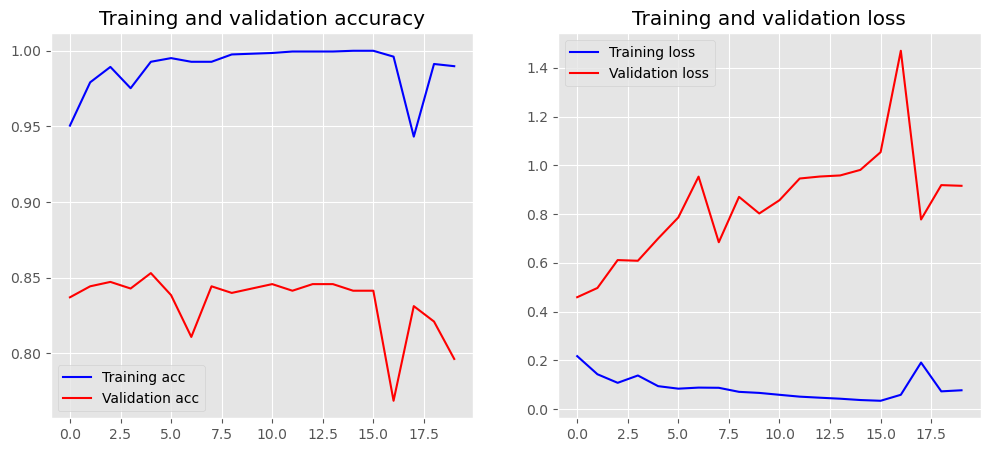

In [ ]:
loss, accuracy = best_model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = best_model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history_kt)

<div class="alert-success">
Indeed, by using hyperparameter tuning, we have better model performance, compared to the last two trained using RNN LSTM. Although after several epochs it begins to deteriorate.
</div>

22/22 [==============================] - 3s 91ms/step


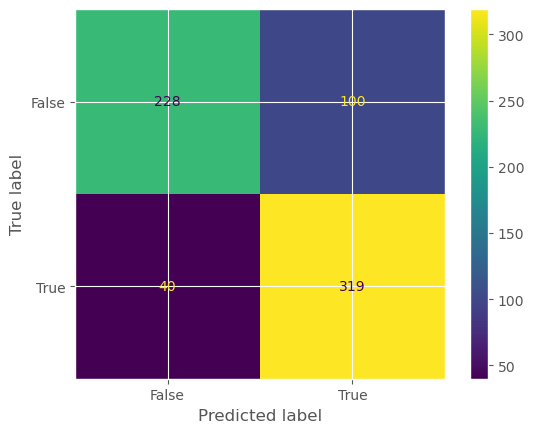

In [ ]:
plot_confusion_matrix(best_model)

<div class="alert-success">
What is observed both in the loss and acc graphs, and in the confession matrix, is that the model may be learning one class better than another. For example, you know how to identify positive reviews well, but not so well negative reviews.
</div>

## Bidirectional LSTM model

Bidirectional LSTMS are a derivative of traditional LSTMs. Here, two LSTMs are used to capture the forward and backward sequences of the input. This helps capture context better than normal LSTM.

Model: "Bidirectional_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          1380900   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              439296    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 1,820,453
Trainable params: 1,820,453
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
33/33 - 54s - loss: 0.5973 - accuracy: 0.6832 - val_loss: 0.5030 - val_accuracy: 0.7918 - 54s/epoch - 2s/step
Epoch 2/20
33/33 - 49s - loss: 0.3801 - accuracy: 0.8384 - val_loss: 0.4303 - val_accuracy: 0.8035 - 49s/epoch

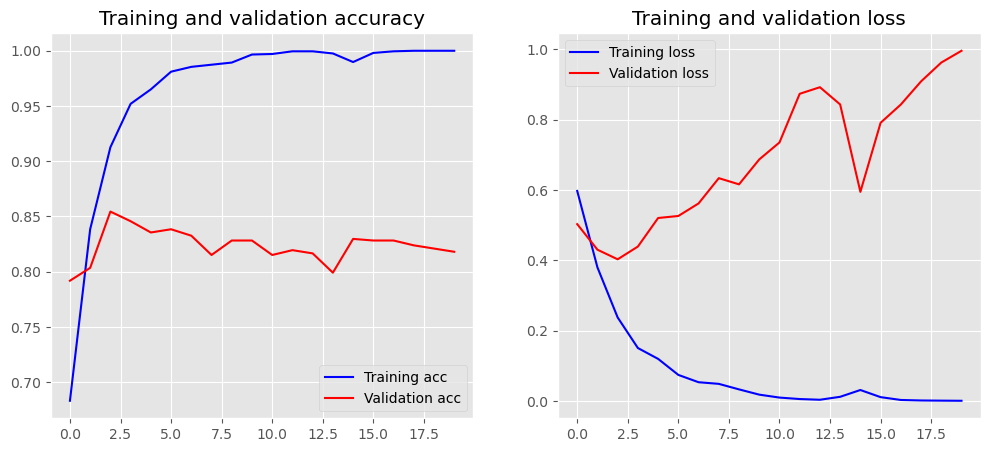

In [ ]:
# Defining Bidirectional LSTM model
keras.utils.set_random_seed(812)

clear_session()
bi_lstm_model = Sequential(name="Bidirectional_LSTM")
bi_lstm_model.add(
    layers.Embedding(
        vocab_size,
        embedding_dim,
        weights=[embedding_matrix],
        input_length=maxlen,
        trainable=True,
    )
)
bi_lstm_model.add(
    layers.Bidirectional(layers.LSTM(128, activation="tanh", return_sequences=False))
)
bi_lstm_model.add(layers.Dense(1, activation="sigmoid"))

# Printing model summary
print(bi_lstm_model.summary())

# Compiling model summary
bi_lstm_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
)

# Training the model
history4 = bi_lstm_model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=20,
    verbose=2,
    validation_data=(X_test, y_test),
)

# Printing model score on test data
print()
print(
    "Bidirectional LSTM model Score---> ",
    bi_lstm_model.evaluate(X_test, y_test, verbose=0),
)

plot_history(history4)

22/22 [==============================] - 9s 324ms/step


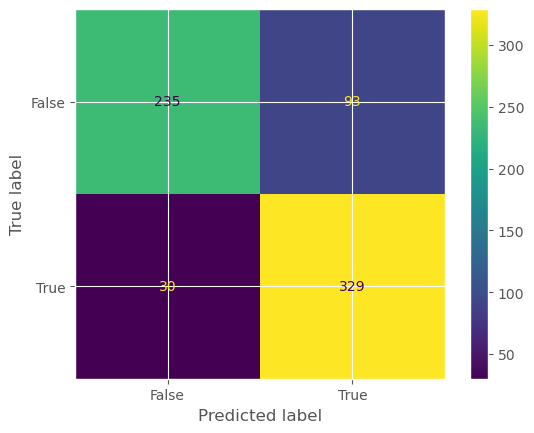

In [ ]:
plot_confusion_matrix(bi_lstm_model)

## Compare all Models

In [ ]:
results = pd.DataFrame(
    {
        "Model": (
            "FFNN",
            "FFNN2",
            "FFNN_EMB",
            "FFNN_EMB_Glob",
            "modelConv1D",
            "glove_F",
            "glove_T",
            "GloveConv1D",
            "RNN",
            "RNN2",
            "best_model",
            "bi_lstm_model",
        )
    }
)

df_yelp = df[df["source"] == "yelp"]
sentences = df_yelp["sentence"].values
y = df_yelp["label"].values

sentences_train, sentences_test, y_train, y_test = train_test_split(
    sentences, y, test_size=0.25, random_state=1000
)

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test = vectorizer.transform(sentences_test)

lossFFNN, accFFNN = FFNN.evaluate(X_test, y_test)

sentences_train, sentences_test, y_train, y_test = train_test_split(
    df["sentence"].values, df["label"].values, test_size=0.25, random_state=1000
)

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test = vectorizer.transform(sentences_test)

lossFFNN2, accFFNN2 = FFNN2.evaluate(X_test, y_test)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

maxlen = 500

X_train = pad_sequences(X_train, padding="post", maxlen=maxlen)
X_test = pad_sequences(X_test, padding="post", maxlen=maxlen)

lossWEFlatten, accWEFlatten = FFNN_EMB.evaluate(X_test, y_test)
lossWEGMP, accWEGMP = FFNN_EMB_Glob.evaluate(X_test, y_test)
lossWEConv1D, accWEConv1D = modelConv1D.evaluate(X_test, y_test)
lossGloVeFalse, accGloVeFalse = glove_F.evaluate(X_test, y_test)
lossGloVeTrue, accGloVeTrue = glove_T.evaluate(X_test, y_test)
lossGloveConv1D, accGloveConv1D = GloveConv1D.evaluate(X_test, y_test)
lossRNN, accRNN = RNN.evaluate(X_test, y_test)
lossRNN2, accRNN2 = RNN2.evaluate(X_test, y_test)
lossbest_model, accbest_model = best_model.evaluate(X_test, y_test)
lossBM, accBM = bi_lstm_model.evaluate(X_test, y_test)

results["ACC"] = [
    accFFNN,
    accFFNN2,
    accWEFlatten,
    accWEGMP,
    accWEConv1D,
    accGloVeFalse,
    accGloVeTrue,
    accGloveConv1D,
    accRNN,
    accRNN2,
    accbest_model,
    accBM,
]

results = results.sort_values(by=("ACC"), ascending=False)

results.set_index("Modelo")

8/8 [==============================] - 0s 3ms/step - loss: 0.6892 - accuracy: 0.7880


22/22 [==============================] - 14s 633ms/step - loss: 0.9954 - accuracy: 0.8180


,ACC
Modelo,
glove_T,0.829694
RNN,0.826783
modelConv1D,0.822416
GloveConv1D,0.819505
FFNN_EMB_Glob,0.818049
bi_lstm_model,0.818049
FFNN2,0.799127
best_model,0.796215
FFNN_EMB,0.790393
